<a href="https://colab.research.google.com/github/RayGone/SentimentAnalysis/blob/phase1/Experiments/BERT%26GPT_Embedding_As_Feature_4SA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers tokenizers datasets huggingface_hub --quiet

import numpy as np
import random
import os
import tensorflow as tf
from transformers import set_seed

rand_seed = 9

def seed_everything(seed=0):
    random.seed(seed) # random
    os.environ['PYTHONHASHSEED'] = str(seed) # python enviroment
    np.random.seed(seed) # numpy
    tf.keras.utils.set_random_seed(seed) # tensorflow
    tf.random.set_seed(seed) # tensorflow
    set_seed(seed) # hugging_face transformer

seed_everything(rand_seed)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 55.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 72.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 45.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 27.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 71.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 21.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 8.8 MB/s eta 0:00:00


## Loading Transformers

In [2]:
from transformers import PreTrainedTokenizerFast, BertTokenizerFast, TFAutoModel
import datasets

gptModel = 'raygx/Nepali-GPT2-CausalLM'
gptTokenizer = PreTrainedTokenizerFast.from_pretrained(gptModel,padding_side='left')
gptModel = TFAutoModel.from_pretrained(gptModel)

bertModel = 'Shushant/nepaliBERT'
bertTokenizer = BertTokenizerFast.from_pretrained(bertModel)
bertModel = TFAutoModel.from_pretrained(bertModel,from_pt=True)

gptModel.config, bertModel.config

All model checkpoint layers were used when initializing TFGPT2Model.

All the layers of TFGPT2Model were initialized from the model checkpoint at raygx/Nepali-GPT2-CausalLM.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2Model for predictions without further training.


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'bert.embeddings.position_ids', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFBertModel were not initialized from the PyTorch model and are newly initialized: ['bert.pooler.dense.weight', 'bert.p

(GPT2Config {
   "_name_or_path": "raygx/Nepali-GPT2-CausalLM",
   "activation_function": "gelu_new",
   "architectures": [
     "GPT2LMHeadModel"
   ],
   "attn_pdrop": 0.1,
   "bos_token_id": 1,
   "embd_pdrop": 0.1,
   "eos_token_id": 2,
   "initializer_range": 0.02,
   "layer_norm_epsilon": 1e-05,
   "model_type": "gpt2",
   "n_ctx": 1024,
   "n_embd": 768,
   "n_head": 12,
   "n_inner": null,
   "n_layer": 12,
   "n_positions": 1024,
   "pad_token_id": 3,
   "reorder_and_upcast_attn": false,
   "resid_pdrop": 0.1,
   "scale_attn_by_inverse_layer_idx": false,
   "scale_attn_weights": true,
   "summary_activation": null,
   "summary_first_dropout": 0.1,
   "summary_proj_to_labels": true,
   "summary_type": "cls_index",
   "summary_use_proj": true,
   "task_specific_params": {
     "text-generation": {
       "do_sample": true,
       "max_length": 50
     }
   },
   "transformers_version": "4.31.0",
   "use_cache": true,
   "vocab_size": 50000
 },
 BertConfig {
   "_name_or_path": "

## Loading Data

In [3]:
print("#######################Using NepCov19Tweets#########################")
data = datasets.load_dataset("raygx/NepCov19TweetsPlus")

data = data.rename_columns({"Sentiment":"label","Sentences":"text"})
data

#######################Using NepCov19Tweets#########################


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/41541 [00:00<?, ? examples/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/raygx___parquet/raygx--NepCov19TweetsPlus-46f98dd56864ead2/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 41541
    })
})

In [4]:
data = data.shuffle(rand_seed)
data = data['train'].train_test_split(test_size=0.2)
data

DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 33232
    })
    test: Dataset({
        features: ['label', 'text'],
        num_rows: 8309
    })
})

In [5]:
def prepareLabels(row):
    if row['label'] == -1:
        row['label'] = 2

    return row

data = data.map(
        prepareLabels,
        num_proc=4)

data

Map (num_proc=4):   0%|          | 0/33232 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/8309 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 33232
    })
    test: Dataset({
        features: ['label', 'text'],
        num_rows: 8309
    })
})

## Creating Embedding Layer

In [6]:
import tensorflow as tf

class GPTEmbedding(tf.keras.layers.Layer):
  def __init__(self, model,tokenizer, max_token_len=128,padding='max_length',trailing_context=4,truncation=True):
    super().__init__()
    self.embedding = model
    self.tokenizer = tokenizer
    self.tokenizer.padding_side = 'left'
    self.max_token = max_token_len
    self.padding = padding
    self.truncation = truncation
    self.trailing_context = trailing_context
    self.trainable=False

  def call(self, x):
    embeddings = self.embedding(
                  self.tokenizer(x,padding=self.padding,truncation=self.truncation,max_length=self.max_token,return_tensors='tf')
                )[0][:,-self.trailing_context:,:]

    return tf.reduce_logsumexp(embeddings,axis=1)

class BERTEmbedding(tf.keras.layers.Layer):
  def __init__(self, model,tokenizer, max_token_len=128,padding='max_length',truncation=True):
    super().__init__()
    self.embedding = model
    self.tokenizer = tokenizer
    self.max_token = max_token_len
    self.padding = padding
    self.truncation = truncation
    self.trainable=False

  def call(self, x):
    return self.embedding(self.tokenizer(x,padding=self.padding,truncation=self.truncation,max_length=self.max_token,return_tensors='tf'))[1]

In [27]:
# model.bert(tokenizer('बैंक तथा वित्तीय संस्थामा देखिएको विश्वासको',padding='max_length',truncation=True,return_tensors='tf',max_length=128))
gpt_embd = GPTEmbedding(gptModel.transformer,gptTokenizer,max_token_len=100,trailing_context=1)
bert_embd = BERTEmbedding(bertModel.bert,bertTokenizer,max_token_len=100)
# embd(["",'बैंक तथा वित्तीय संस्थामा देखिएको विश्वासको','बैंक तथा वित्तीय संस्थामा देखिएको विश्वासको'])
d_model = tf.concat([gpt_embd(["abcd",'efgh']),bert_embd(["abcd",'efgh'])],axis=1).shape[1]
d_model

1536

## Creating Data Generator

In [32]:
class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, data,model_dim, batch_size=32,shuffle=True):
        'Initialization'
        self.batch_size = batch_size
        self.data = data
        self.embeddings = np.empty((data.num_rows,model_dim))
        self.shuffle = shuffle
        # self.average = tf.keras.layers.Average()
        self.is_first_epoch = True
        self.on_epoch_end(is_first_epoch=self.is_first_epoch)

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.ceil(self.data.num_rows / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        return self.__data_generation(indexes)

    def on_epoch_end(self,is_first_epoch=False):
        'Updates indexes after each epoch'
        self.indexes = np.arange(self.data.num_rows)
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

        self.is_first_epoch = is_first_epoch


    def __data_generation(self, indexes):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        chunk = self.data.select(indexes)

        if self.is_first_epoch:
          X = tf.concat([gpt_embd(chunk['text']), bert_embd(chunk['text'])],axis=1)
          self.embeddings[indexes] = X
        else:
          X = self.embeddings[indexes]

        y = np.array(chunk['label'])
        return X,y

In [33]:
%%time

train_features = DataGenerator(data['train'],model_dim=d_model,batch_size=32)
test_features = DataGenerator(data['test'],model_dim=d_model,shuffle=False)

CPU times: user 2.44 ms, sys: 33 µs, total: 2.47 ms
Wall time: 5.13 ms


## Classification Head

In [34]:
model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=(d_model)),
    tf.keras.layers.Dense(768,activation='gelu'),
    tf.keras.layers.Dropout(0.15),
    tf.keras.layers.Dense(3,activation='softmax')
])

model.compile(
  optimizer=tf.keras.optimizers.Adam(
        learning_rate=2e-5,
        weight_decay=0.001
      ),
  loss='sparse_categorical_crossentropy',
  metrics=['acc'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 768)               1180416   
                                                                 
 dropout_77 (Dropout)        (None, 768)               0         
                                                                 
 dense_10 (Dense)            (None, 3)                 2307      
                                                                 
Total params: 1,182,723
Trainable params: 1,182,723
Non-trainable params: 0
_________________________________________________________________


## Training Classification

In [35]:
history = model.fit(train_features,
        epochs=100,
        validation_data=test_features,
        callbacks=[tf.keras.callbacks.EarlyStopping(
                            monitor='val_acc', patience=3,
                            verbose=1, mode='auto',
                            restore_best_weights=True)
                        ])

Epoch 1/100
1039/1039 [==============================] - 714s 685ms/step - loss: 0.8885 - acc: 0.6242 - val_loss: 0.7265 - val_acc: 0.6884
Epoch 2/100
1039/1039 [==============================] - 8s 8ms/step - loss: 0.7123 - acc: 0.6968 - val_loss: 0.6827 - val_acc: 0.7067
Epoch 3/100
1039/1039 [==============================] - 10s 9ms/step - loss: 0.6551 - acc: 0.7206 - val_loss: 0.6647 - val_acc: 0.7173
Epoch 4/100
1039/1039 [==============================] - 10s 10ms/step - loss: 0.6179 - acc: 0.7386 - val_loss: 0.6456 - val_acc: 0.7278
Epoch 5/100
1039/1039 [==============================] - 8s 8ms/step - loss: 0.5871 - acc: 0.7529 - val_loss: 0.6378 - val_acc: 0.7310
Epoch 6/100
1039/1039 [==============================] - 10s 9ms/step - loss: 0.5632 - acc: 0.7653 - val_loss: 0.6320 - val_acc: 0.7364
Epoch 7/100
1039/1039 [==============================] - 10s 10ms/step - loss: 0.5438 - acc: 0.7745 - val_loss: 0.6223 - val_acc: 0.7399
Epoch 8/100
1039/1039 [======================

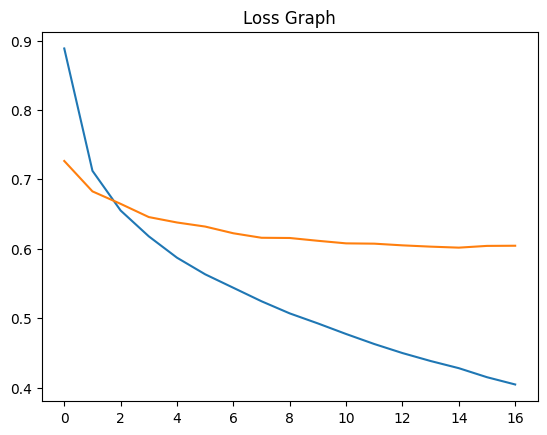

Text(0.5, 1.0, 'Accuracy Graph')

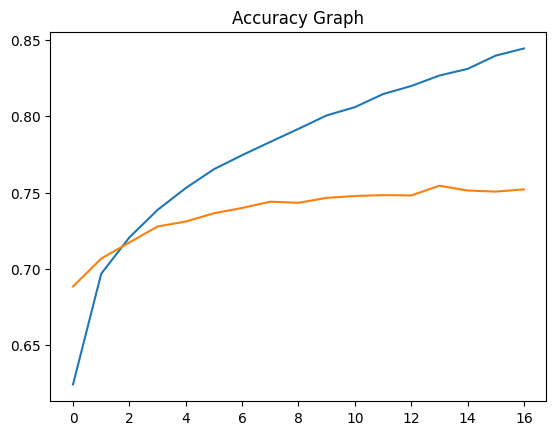

In [36]:
import seaborn
from matplotlib import pyplot as plt

seaborn.lineplot(history.history['loss'])
seaborn.lineplot(history.history['val_loss'])
plt.title("Loss Graph")
plt.show()

seaborn.lineplot(history.history['acc'])
seaborn.lineplot(history.history['val_acc'])
plt.title("Accuracy Graph")

## Model Evaluation

In [37]:
%%time
from transformers import pipeline, TextClassificationPipeline

print("Getting Test Prediction")
pred_labels = [np.argmax(x) for x in model.predict(test_features)]

actual_labels = data['test']['label']

Getting Test Prediction
260/260 [==============================] - 1s 4ms/step
CPU times: user 1.35 s, sys: 76.6 ms, total: 1.43 s
Wall time: 1.25 s


In [38]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

print("F1-Score",f1_score(actual_labels,pred_labels,average='weighted'))
print("Precision-Score",precision_score(actual_labels,pred_labels,average='weighted'))
print("Recall-Score",recall_score(actual_labels,pred_labels,average='weighted'))
print("accuracy_Score",accuracy_score(actual_labels,pred_labels))

F1-Score 0.754529329359977
Precision-Score 0.7575192705443596
Recall-Score 0.7544830906246239
accuracy_Score 0.7544830906246239


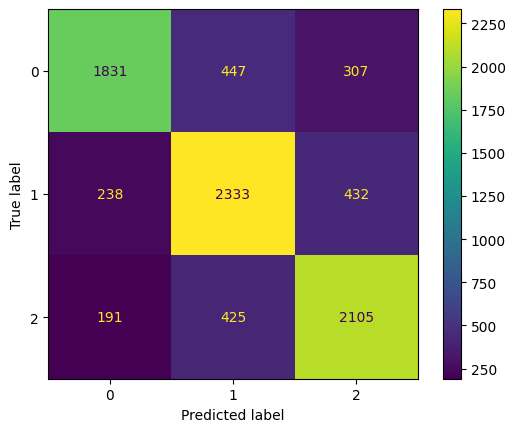

In [39]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cmd = ConfusionMatrixDisplay(tf.math.confusion_matrix(actual_labels,pred_labels,num_classes=3).numpy())
cmd.plot()